In [99]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as ex
import plotly.graph_objs as go
import string
import re
import nltk

from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
import collections
plt.rc('figure',figsize=(20,11))

from scipy.stats import zscore

from nltk.corpus import stopwords

<IPython.core.display.Javascript object>

In [2]:
def RMSE(Y,YHAT):
    return np.sqrt(mean_squared_error(Y,YHAT))

In [3]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [4]:
df=pd.read_csv('AB_US_2020.csv')

C:\Users\rissu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning:

Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [6]:
df.drop(columns=['host_id','host_name','neighbourhood_group','neighbourhood'],inplace=True)

In [7]:
df.head()

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


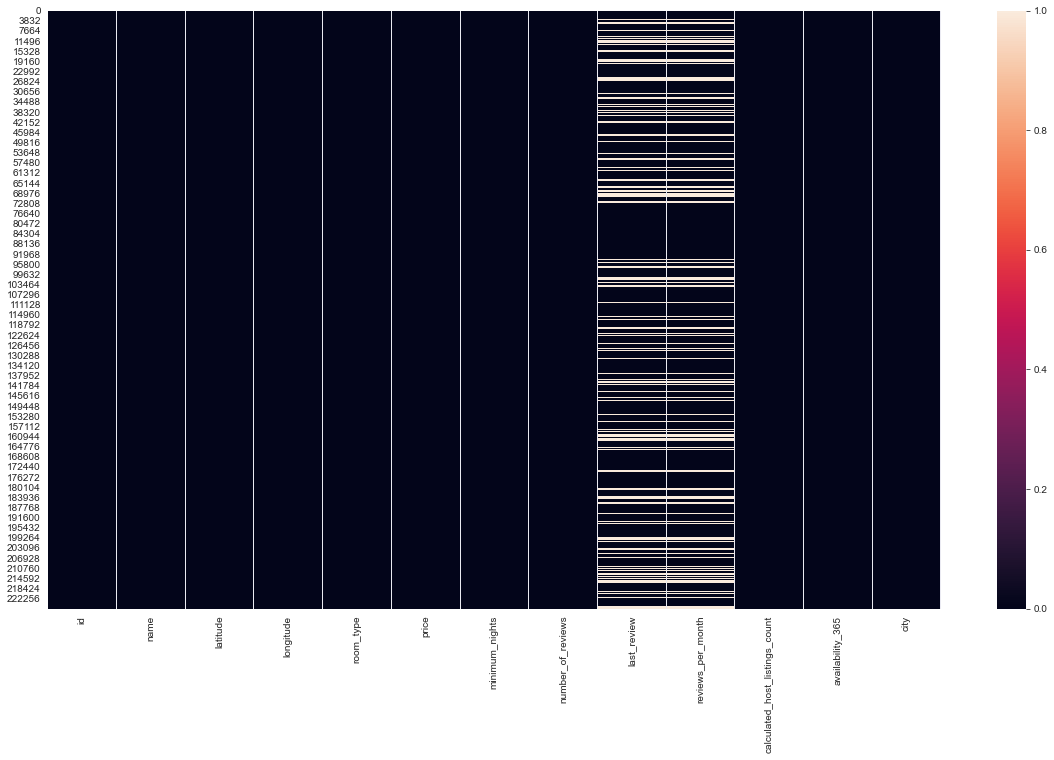

In [8]:
sns.heatmap(df.isna())

In [9]:
df.isnull().sum()/len(df)

id                                0.000000
name                              0.000124
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.215025
reviews_per_month                 0.215025
calculated_host_listings_count    0.000000
availability_365                  0.000000
city                              0.000000
dtype: float64

In [10]:
df['last_review']=pd.to_datetime(df['last_review'])

In [11]:
df.dtypes

id                                         int64
name                                      object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
city                                      object
dtype: object

In [12]:
numeric_features=[col for col in df.columns if df[col].dtypes !='O']
del numeric_features[0]
del numeric_features[5]
numeric_features

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [13]:
catagoric_features=[col for col in df.columns if df[col].dtypes=='O']
catagoric_features

['name', 'room_type', 'city']

In [14]:
df=df.dropna()
df.head()

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,35.65146,-82.62792,Private room,60,1,138,2020-02-16,1.14,1,0,Asheville
1,80905,French Chic Loft,35.59779,-82.55540,Entire home/apt,470,1,114,2020-07-09,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,35.60670,-82.55563,Entire home/apt,75,30,89,2019-11-30,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,35.57864,-82.59578,Entire home/apt,90,1,267,2020-09-22,2.39,5,0,Asheville
4,160594,Historic Grove Park,35.61442,-82.54127,Private room,125,30,58,2015-10-19,0.52,1,0,Asheville


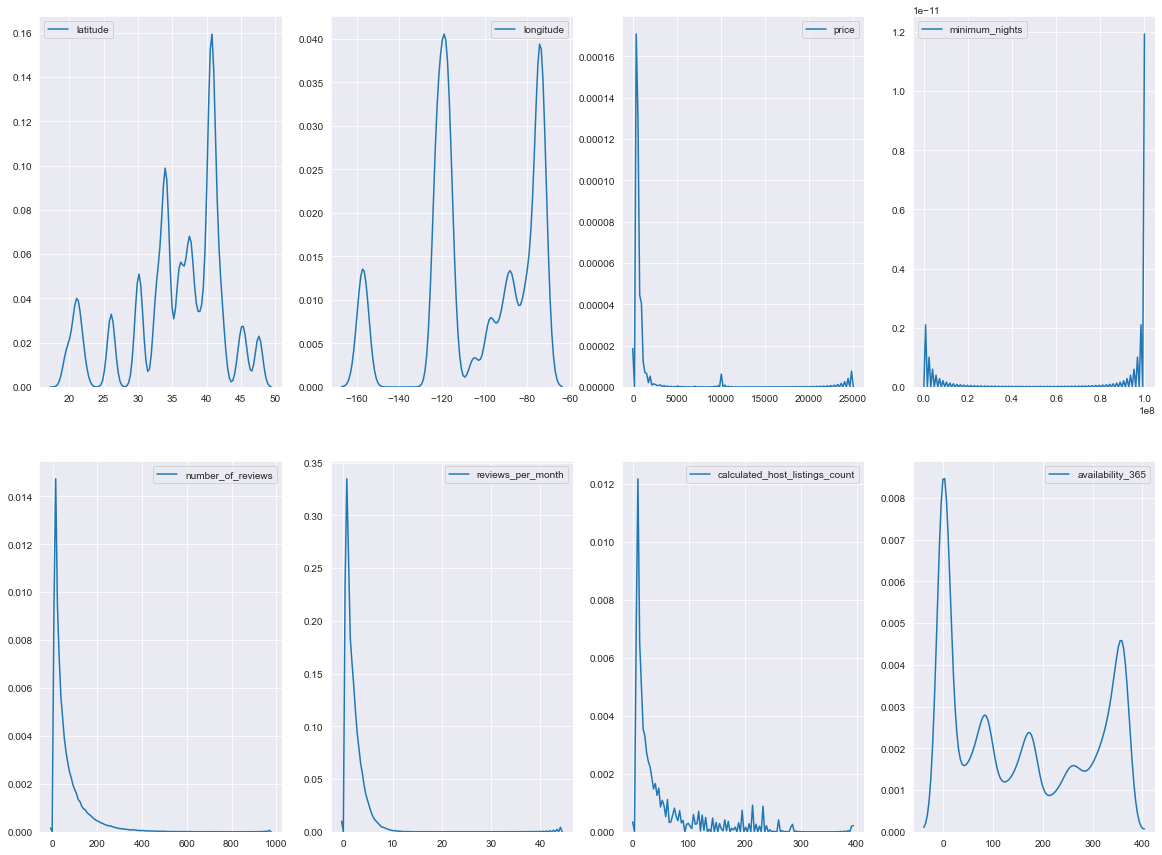

In [15]:
fig,axes=pl.subplots(nrows=2,ncols=4)
fig.set_figheight(15)
fig.set_figwidth(20)
aux=0
for row in axes:
    for col in row:
        sns.kdeplot(df[numeric_features[aux]],ax=col)
        aux+=1

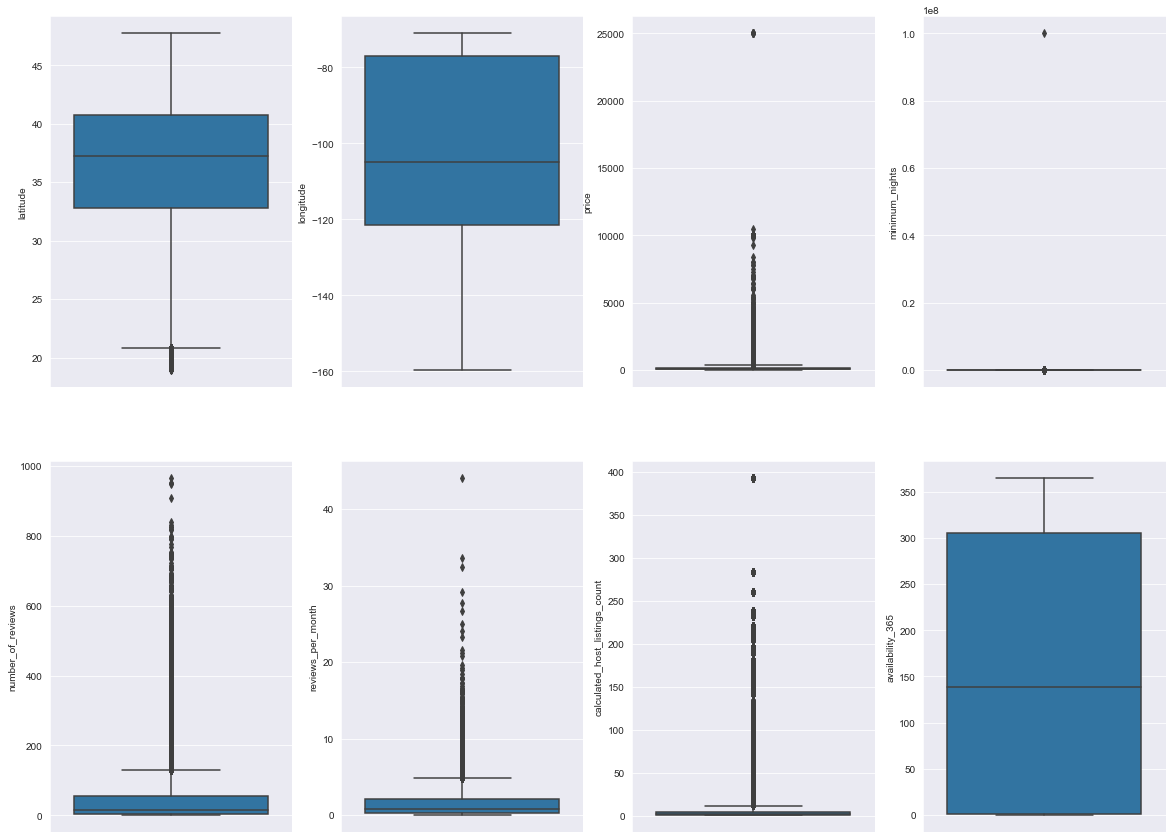

In [16]:
fig,axes=pl.subplots(nrows=2,ncols=4)
fig.set_figheight(15)
fig.set_figwidth(20)
aux=0
for row in axes:
    for col in row:
        sns.boxplot(y=df[numeric_features[aux]],ax=col)
        aux+=1

In [17]:
lower_bound=.25
upper_bound=.75
iqr=df[df['price'].between(df['price'].quantile(lower_bound),df['price'].quantile(upper_bound),inclusive=True)]


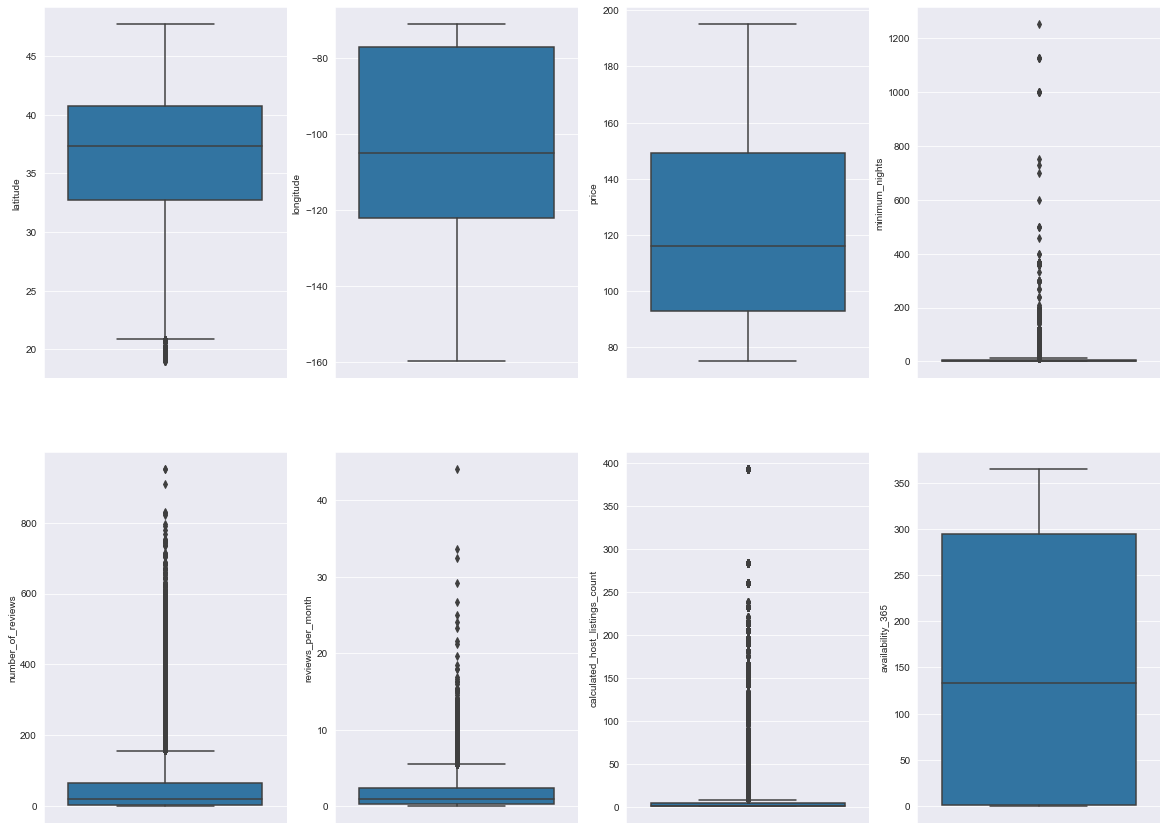

In [18]:
fig,axes=pl.subplots(nrows=2,ncols=4)
fig.set_figheight(15)
fig.set_figwidth(20)
aux=0
for row in axes:
    for col in row:
        sns.boxplot(y=iqr[numeric_features[aux]],ax=col)
        aux+=1

In [19]:
iqr=iqr[iqr['number_of_reviews']>0]
iqr=iqr[iqr['calculated_host_listings_count']<10]
iqr=iqr[iqr['number_of_reviews']<200]
iqr=iqr[iqr['minimum_nights']<10]
iqr=iqr[iqr['reviews_per_month']<5]

In [20]:
iqr.shape,df.shape

((54240, 13), (177417, 13))

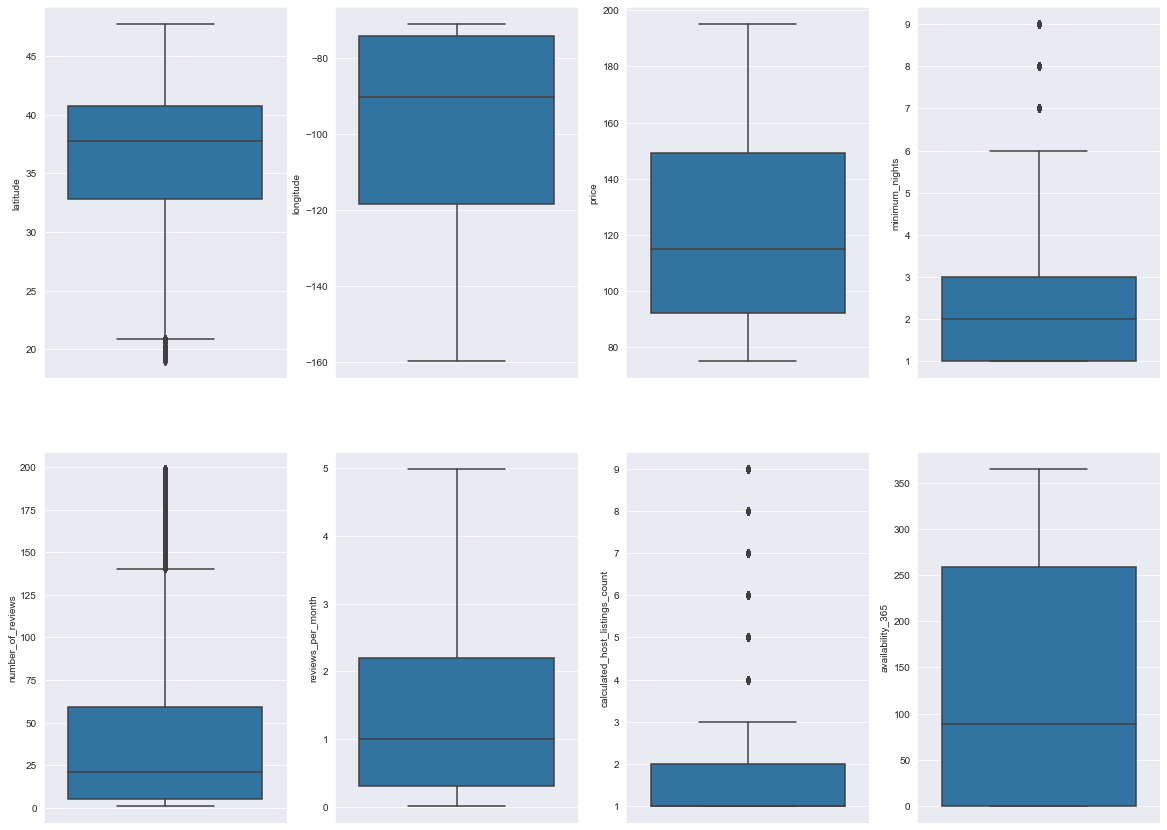

In [21]:
fig,axes=pl.subplots(nrows=2,ncols=4)
fig.set_figheight(15)
fig.set_figwidth(20)
aux=0
for row in axes:
    for col in row:
        sns.boxplot(y=iqr[numeric_features[aux]],ax=col)
        aux+=1

In [22]:
df1=df[numeric_features].copy()
z_scores = zscore(df1)

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df1[filtered_entries].copy()

new_df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,35.65146,-82.62792,60,1,138,1.14,1,0
1,35.59779,-82.55540,470,1,114,1.03,11,288
2,35.60670,-82.55563,75,30,89,0.81,2,298
4,35.61442,-82.54127,125,30,58,0.52,1,0
5,35.61856,-82.55276,134,7,54,0.49,1,294


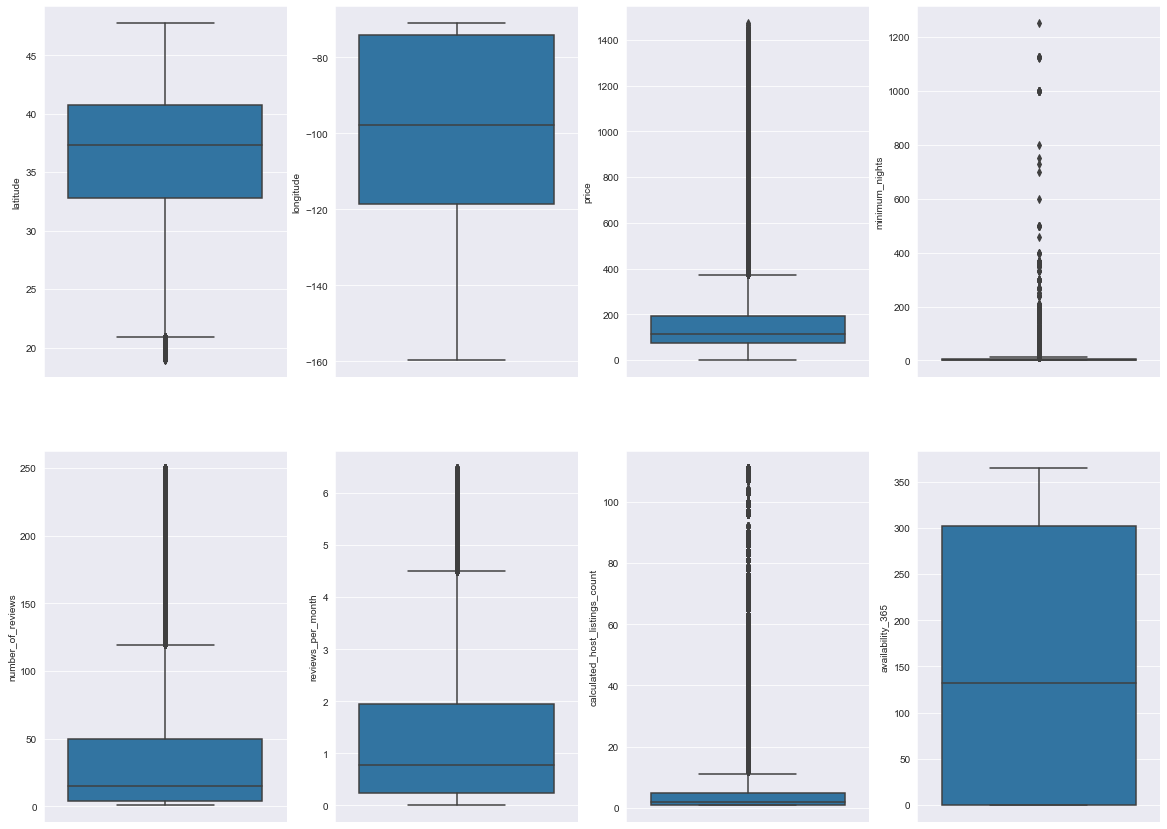

In [23]:
fig,axes=pl.subplots(nrows=2,ncols=4)
fig.set_figheight(15)
fig.set_figwidth(20)
aux=0
for row in axes:
    for col in row:
        sns.boxplot(y=new_df[numeric_features[aux]],ax=col)
        aux+=1

In [31]:
pr_data=iqr.copy()
desc=pr_data.describe()
desc.loc['skew']=desc.skew()
desc.loc['skew']=desc.kurt()
pd.set_option('display.float_format',lambda x: '%.5f' %x)
desc.drop(columns='id').style.highlight_max(axis=1)



,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,54240.000000,54240.000000,54240.000000,54240.000000,54240.000000,54240.000000,54240.000000,54240.000000
mean,36.307159,-99.267071,120.667294,2.390542,39.813735,1.378966,1.980033,134.104369
std,6.667770,25.668656,33.378540,1.451466,45.533609,1.244052,1.731882,133.816255
min,18.982320,-159.711430,75.000000,1.000000,1.000000,0.010000,1.000000,0.000000
25%,32.794785,-118.393597,92.000000,1.000000,5.000000,0.300000,1.000000,0.000000
50%,37.807440,-90.089645,115.000000,2.000000,21.000000,1.000000,1.000000,89.000000
75%,40.732870,-73.988910,149.000000,3.000000,59.000000,2.190000,2.000000,259.000000
max,47.734620,-70.995950,195.000000,9.000000,199.000000,4.990000,9.000000,365.000000
skew,8.999981,8.999744,8.999737,9.000000,8.999706,9.000000,9.000000,8.998783


In [33]:
ex.pie(names=pr_data.room_type,title='Distribution of Different Room Types')

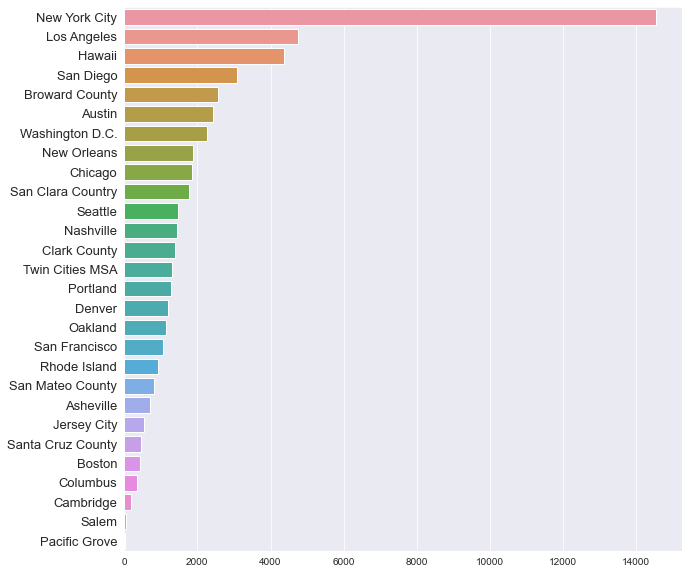

In [52]:
pl.figure(figsize=(10,10))
temp=iqr['city'].value_counts()
sns.barplot(y=temp.keys(),x=temp.values)
pl.yticks(fontsize=13)
pl.show()

In [79]:
fig=go.Figure(go.Bar(
x=temp.keys(),
y=temp.values,
    text=temp.values,
    textposition='inside',
)
             )
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)

fig.show()


In [80]:
states_dic = {'Asheville':'NC','Austin':'TX','Boston':'MA','Broward County':'FL','Cambridge':'MA','Chicago':'IL','Clark County':'NV','Columbus':'OH','Denver':'CO','Hawaii':'HI','Jersey City':'NJ',
             'Los Angeles':'SC','Nashville':'TN','New Orleans':'MS','New York City':'NY','Oakland':'CA','Pacific Grove':'CA','Portland':'OR','Rhode Island':'RI','Salem':'MA','San Clara Country':'CA',
             'Santa Cruz County':'CA','San Diego':'CA','San Francisco':'CA','San Mateo County':'CA','Seattle':'WA','Twin Cities MSA':'MN','Washington D.C.':'DC'}

pr_data['state'] = pr_data['city'].apply(lambda x : states_dic[x])

In [82]:
pr_data.head()

,id,name,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,state
5,209068,Terrace Cottage,35.61856,-82.55276,Entire home/apt,134,7,54,2020-01-14,0.49000,1,294,Asheville,NC
12,427497,Luxurious Mountain Guest Suite Apartment,35.49111,-82.48438,Entire home/apt,125,2,40,2020-08-17,0.42000,1,339,Asheville,NC
20,634319,Private Asheville Cabin Apartment,35.62839,-82.47989,Entire home/apt,150,3,30,2019-01-09,0.31000,1,266,Asheville,NC
25,723349,#2 Blue Ridge Room at Oakland Cottage B&B,35.57468,-82.55705,Private room,169,2,7,2020-07-13,0.09000,7,0,Asheville,NC
27,751963,Come Home in West Asheville!,35.57805,-82.58342,Entire home/apt,95,1,100,2018-10-28,1.10000,1,252,Asheville,NC


In [92]:
counts=pr_data['state'].value_counts()
fig=ex.choropleth(locations=counts.index,color=counts.values,locationmode='USA-states',
                 scope='usa',title='Number of listings by state',color_continuous_scale=ex.colors.diverging.Portland)

fig.show()

In [93]:
g_dat = pr_data.groupby(by='state').mean()
#g_dat = g_dat.reset_index()
fig = ex.choropleth(g_dat,locations=g_dat.index,color='price', locationmode="USA-states", scope="usa",title='Average Listing Price At Each State', color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

In [94]:
g_dat.head()

,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
state,,,,,,,,,
CA,23217203.49892,35.76517,-120.32789,120.73493,2.24778,43.07374,1.49083,2.15422,124.56450
CO,25453715.07083,39.74178,-104.97925,114.60624,1.99831,43.00253,1.75426,1.45110,87.92411
DC,23057495.94670,38.91317,-77.01845,115.29780,2.26608,41.01366,1.33454,1.80617,115.21630
FL,27863920.14435,26.10498,-80.14671,121.51145,2.62165,26.84905,1.29227,2.97866,194.30927
HI,22119203.91422,20.66112,-156.87408,130.46055,2.62821,48.29610,1.40900,2.48991,213.67018


In [95]:
fig = ex.choropleth(g_dat,locations=g_dat.index,color='number_of_reviews',
                    locationmode="USA-states", scope="usa",
                    title='Average Listing Number Of Reviews At Each State',
                    color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

In [96]:
fig = ex.choropleth(g_dat,locations=g_dat.index,color='availability_365',
                    locationmode="USA-states", scope="usa",
                    title='Average Listing Number Of Reviews At Each State',
                    color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

In [124]:
pr_data['name'].head()

5                               Terrace Cottage
12     Luxurious Mountain Guest Suite Apartment
20            Private Asheville Cabin Apartment
25    #2 Blue Ridge Room at Oakland Cottage B&B
27                 Come Home in West Asheville!
Name: name, dtype: object

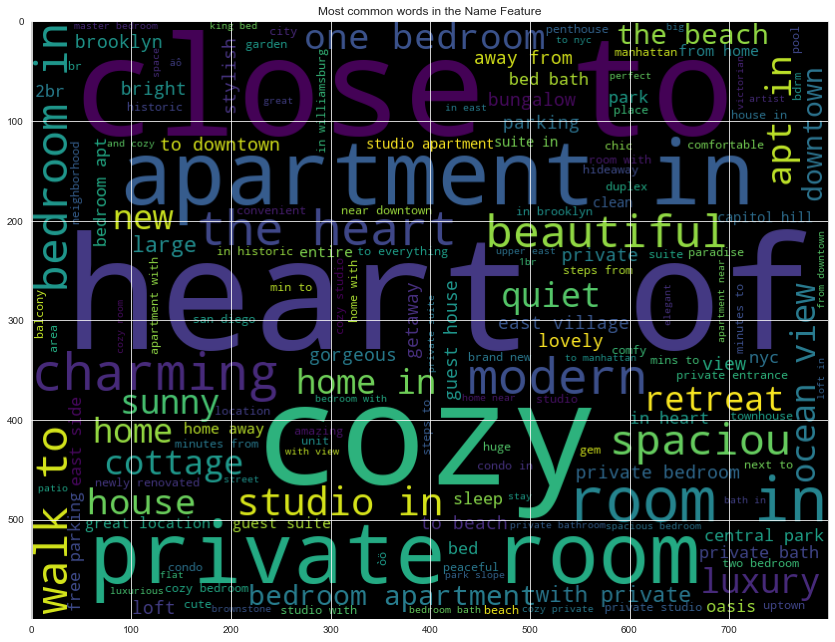

In [107]:
pl.imshow(WordCloud(width=800,
                   height=600,
                    min_font_size=10,
                    stopwords=stopwords.words('english')
                       ).generate(' '.join(pr_data['name'].str.lower().values)))
pl.title("Most common words in the Name Feature")

pl.show()

In [119]:
vocab=collections.Counter(' '.join(pr_data['name']).split(' '))
max_length=max(pr_data['name'].apply(lambda x: len(x)))
vocab_size=len(vocab.keys())


encoded_docs=[tf.keras.preprocessing.text.one_hot(d,vocab_size) for d in pr_data.name]
encoded_docs[:10]

[[24503, 27738],
 [19533, 17547, 2435, 19129, 18272],
 [14400, 24771, 17026, 18272],
 [28839, 27790, 21884, 3556, 20114, 30933, 27738, 28913, 28913],
 [27382, 548, 15325, 8922, 24771],
 [24761, 6856, 17547, 17741, 13266],
 [22212, 27738, 6900, 31041, 23845, 30196, 13303, 29187, 23712, 9757],
 [30495, 548, 15325, 14373, 9757, 6210, 29810, 3850, 1503, 17525],
 [11690, 548, 6511, 2243, 13303, 29187, 24901],
 [26442, 27843, 2243, 3309, 2473, 24901, 9757]]

In [121]:
padded_docs=tf.keras.preprocessing.sequence.pad_sequences(encoded_docs,maxlen=max_length,
                                                         padding='post')
padded_docs[:5]

array([[24503, 27738,     0, ...,     0,     0,     0],
       [19533, 17547,  2435, ...,     0,     0,     0],
       [14400, 24771, 17026, ...,     0,     0,     0],
       [28839, 27790, 21884, ...,     0,     0,     0],
       [27382,   548, 15325, ...,     0,     0,     0]])

In [122]:
padded_docs_eval=padded_docs[:1000].copy()
padded_docs_t=padded_docs[1000:].copy()
y=pr_data.price[1000:]
y_eval=pr_data.price[:1000]